In [1]:
# LSTM 有两层 LSTM 的结构

In [39]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的
TEST_BATCH_COUNT = 3

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LENGTH, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - TEST_BATCH_COUNT
test_batch_count = TEST_BATCH_COUNT

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(250, 123)
rolling_data shape: (191, 60, 123)
seq count: 191
seq length: 60
total batch count: 191
batch size: 1
rolling_data: torch.Size([191, 1, 60, 123])
train_x: torch.Size([188, 1, 60, 122])
train_y: torch.Size([188, 1, 60, 1])
test_x:  torch.Size([3, 1, 60, 122])
test_y:  torch.Size([3, 1, 60, 1])
train_batch_count: 188
test_batch_count:  3


In [40]:
# 定义 LSTM 模型
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = dataset.shape[1]-1
HIDDEN_SIZE = 768
NUM_LAYERS = 1


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        # self.linear_1 = nn.Linear(input_size, int(hidden_layer_size/4))
        self.dropout = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=int(hidden_layer_size/2), num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=int(hidden_layer_size/2), hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)

        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        # self.init_weights3()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
    
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        # x = self.linear_1(x)
        # x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (self.h10, self.c10))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm_out, (h_n, c_n) = self.lstm2(lstm1_out, (self.h20, self.c20))

        lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions


0 of 20 epoch loss: 0.777770
1 of 20 epoch loss: 0.587365
2 of 20 epoch loss: 0.302049
3 of 20 epoch loss: 0.173432
4 of 20 epoch loss: 0.094614
5 of 20 epoch loss: 0.067122
6 of 20 epoch loss: 0.054705
7 of 20 epoch loss: 0.045850
8 of 20 epoch loss: 0.036515
9 of 20 epoch loss: 0.033451
10 of 20 epoch loss: 0.029080
11 of 20 epoch loss: 0.023316
12 of 20 epoch loss: 0.022691
13 of 20 epoch loss: 0.020351
14 of 20 epoch loss: 0.020877
15 of 20 epoch loss: 0.019035
16 of 20 epoch loss: 0.018941
17 of 20 epoch loss: 0.016757
18 of 20 epoch loss: 0.015726
19 of 20 epoch loss: 0.015296


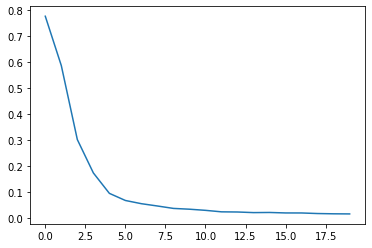

In [24]:
# 训练 LSTM 模型
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-3
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)


# 训练 LSTM 模型; 
epoches = 20
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step])
        loss = loss_func(pred, train_y[step])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data
        
    if loss.item() < 1e-6:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, epoch_loss.item()))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
    # for p in optimizer.param_groups:
    #     p['lr'] *= 0.95
    


plt.plot(epoch_loss_list)
plt.show()    

Prediction: 0.01 ---- Actual: -0.02
Prediction: -0.01 ---- Actual: -0.08
Prediction: 0.02 ---- Actual: -0.13
All Test Loss:0.005597


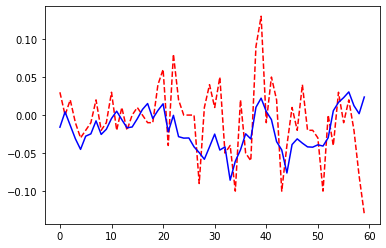

In [48]:
# 预测数据
test_loss = 0

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred, test_y[step])

    print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))
    
    test_loss += loss.cpu()
    
    # print("loss : {:.6f}".format(float(loss.data)))

    # print(test_y[step][-1].flatten().shape)
    # print(pred[-1].flatten().shape)
    
    # actual_line = test_y[step][-1].cpu().detach().flatten().numpy()
    # pred_line   = pred[-1].cpu().detach().flatten().numpy()
    
print("All Test Loss:{:.6f}".format(test_loss.data))

actual_line = test_y[step].cpu().detach().flatten().numpy()
pred_line   = pred.cpu().detach().flatten().numpy()
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()


# actual_line = np.array(test_y[-1]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

# actual_line = np.array(test_y[0][-1]).flatten().tolist()
# pred_line = pred[-1].data.numpy().flatten().tolist()




0 of 20 epoch loss: 1.587730
1 of 20 epoch loss: 0.774519
2 of 20 epoch loss: 0.697546
3 of 20 epoch loss: 0.692547
4 of 20 epoch loss: 0.690905
5 of 20 epoch loss: 0.679319
6 of 20 epoch loss: 0.656361
7 of 20 epoch loss: 0.654246
8 of 20 epoch loss: 0.605371
9 of 20 epoch loss: 0.584372
10 of 20 epoch loss: 0.586394
11 of 20 epoch loss: 0.528567
12 of 20 epoch loss: 0.498703
13 of 20 epoch loss: 0.554869
14 of 20 epoch loss: 0.470889
15 of 20 epoch loss: 0.436203
16 of 20 epoch loss: 0.394254
17 of 20 epoch loss: 0.375400
18 of 20 epoch loss: 0.407763
19 of 20 epoch loss: 0.341992


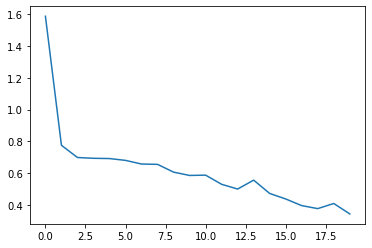

In [49]:
# 训练 LSTM 模型 ---- 只计算最后的LOSS
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-3
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)


# 训练 LSTM 模型; 
epoches = 20
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step])
        loss = loss_func(pred[-1][-1], train_y[step][-1][-1])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data
        
    if loss.item() < 1e-6:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, epoch_loss.item()))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
    # for p in optimizer.param_groups:
    #     p['lr'] *= 0.95
    


plt.plot(epoch_loss_list)
plt.show()    

Prediction: -0.00 ---- Actual: -0.02
Prediction: -0.02 ---- Actual: -0.08
Prediction: 0.04 ---- Actual: -0.13
Prediction Loss:0.032373


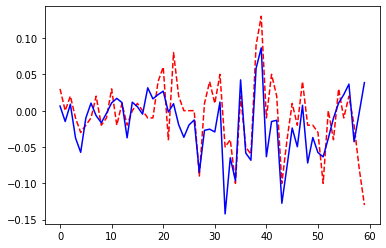

In [52]:
# 预测数据
test_loss = 0

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred[-1][-1], test_y[step][-1][-1])

    print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))
    
    test_loss += loss.cpu()
    
    # print("loss : {:.6f}".format(float(loss.data)))

    # print(test_y[step][-1].flatten().shape)
    # print(pred[-1].flatten().shape)
    
    # actual_line = test_y[step][-1].cpu().detach().flatten().numpy()
    # pred_line   = pred[-1].cpu().detach().flatten().numpy()
    
print("Prediction Loss:{:.6f}".format(test_loss.data))

actual_line = test_y[step].cpu().detach().flatten().numpy()
pred_line   = pred.cpu().detach().flatten().numpy()
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()


# actual_line = np.array(test_y[-1]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

# actual_line = np.array(test_y[0][-1]).flatten().tolist()
# pred_line = pred[-1].data.numpy().flatten().tolist()


